# 2.2. Modelos Lineales

## Setup

In [2]:
# Módulos
import os
from kaggle.api.kaggle_api_extended import KaggleApi
import opendatasets as od
import session_info

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.stattools import durbin_watson

from sklearn import set_config

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

import warnings

set_config(transform_output="pandas")
sns.set_theme(style='darkgrid')
%matplotlib inline
warnings.filterwarnings("ignore")
warnings.filterwarnings('ignore', category=FutureWarning, module='seaborn')


dir_data = '../03_Data/'

In [3]:
session_info.show()

In [4]:
def general_diagnosis(y_real,y_predicted,alpha):
    residual = y_real - y_predicted
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(9, 8))

    axes[0, 0].scatter(y_real, y_predicted, edgecolors=(0, 0, 0), alpha = 0.4)
    axes[0, 0].plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()],
                    'k--', color = 'black', lw=2)
    axes[0, 0].set_title('Valor predicho vs valor real', fontsize = 10, fontweight = "bold")
    axes[0, 0].set_xlabel('Real')
    axes[0, 0].set_ylabel('Predicción')
    axes[0, 0].tick_params(labelsize = 7)

    plot_acf(residual, lags=20, ax=axes[0, 1])
    axes[0, 1].set_title('Autocorrelación de Residuos', fontsize=10, fontweight='bold')
    axes[0, 1].tick_params(labelsize=7)

    sns.histplot(
        data    = residual,
        stat    = "density",
        kde     = True,
        line_kws= {'linewidth': 1},
        color   = "firebrick",
        alpha   = 0.3,
        ax      = axes[1, 0]
    )

    axes[1, 0].set_title('Distribución residuos del modelo', fontsize = 10,
                        fontweight = "bold")
    axes[1, 0].set_xlabel("Residuo")
    axes[1, 0].tick_params(labelsize = 7)

    sm.qqplot(
        residual,
        fit   = True,
        line  = 'q',
        ax    = axes[1, 1], 
        color = 'firebrick',
        alpha = 0.4,
        lw    = 2
    )
    axes[1, 1].set_title('Q-Q residuos del modelo', fontsize = 10, fontweight = "bold")
    axes[1, 1].tick_params(labelsize = 7)

    axes[2, 0].scatter(y_predicted, residual,
                    edgecolors=(0, 0, 0), alpha = 0.4)
    axes[2, 0].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
    axes[2, 0].set_title('Residuos del modelo vs predicción', fontsize = 10, fontweight = "bold")
    axes[2, 0].set_xlabel('Predicción')
    axes[2, 0].set_ylabel('Residuo')
    axes[2, 0].tick_params(labelsize = 7)

    fig.delaxes(axes[2,1])
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)
    fig.suptitle('Diagnóstico residuos', fontsize = 12, fontweight = "bold");
    
    # Normalidad Tests:
    p_value_shapiro = round(stats.shapiro(residual)[1],5)
    if p_value_shapiro < alpha:
        print(f'Shapiro-Wilk Test: Debe rechazarse la hipótesis nula de que los datos proceden de una distribución normal. P-value: {p_value_shapiro}')
    else:
        print(f"Shapiro-Wilk Test: Se acepta la hipótesis nula de que los datos proceden de una distribución normal. P-value: {p_value_shapiro}")
    
    p_value_dagostino = round(stats.normaltest(residual)[1],5)
    if p_value_dagostino < alpha:
        print(f"D'Agostino Test: Debe rechazarse la hipótesis nula de que los datos proceden de una distribución normal. P-value: {p_value_dagostino}")

    # Durbin-Watson Test para autocorrelación
    durbin_watson_statistic = durbin_watson(residual)
    if durbin_watson_statistic < 1.5:
        print(f"Estadístico de Durbin-Watson: {durbin_watson_statistic}: Indicios de autocorrelación positiva.")
    elif durbin_watson_statistic > 2.5:
        print(f"Estadístico de Durbin-Watson: {durbin_watson_statistic}: Indicios de autocorrelación negativa.")
    else:
        print(f"Estadístico de Durbin-Watson: {durbin_watson_statistic}: No hay indicios significativos de autocorrelación.")
def boxplot_target(var_cat,target,figsize = (12, 10)):
    n_variables = len(var_cat)
    n_filas = n_variables // 2
    n_columnas = 2 if n_variables % 2 == 0 else 3

    fig, axes = plt.subplots(nrows=n_filas, ncols=n_columnas, figsize=figsize)

    for i, cat in enumerate(var_cat):
        fila = i // n_columnas
        columna = i % n_columnas
        sns.boxplot(x=cat, y=target, data=df, ax=axes[fila, columna])
        axes[fila, columna].set_title(f'Boxplot de {cat} vs. charges')
        axes[fila, columna].set_ylabel('Charges')
        axes[fila, columna].set_xlabel(cat)
        
    plt.tight_layout()
    plt.show()
def get_extreme_values(df, target, lower_percentile=0.01, upper_percentile=0.99):
    lower_bound = df[target].quantile(lower_percentile)
    upper_bound = df[target].quantile(upper_percentile)
    return df[(df[target] < lower_bound) | (df[target] > upper_bound)][target]

## 2.2.1. Regresión Lineal

Haciendo un resumen de lo más sencillo a lo más complejo, toquemos más a fondo la *regresión lineal simple* y su generalización la *regresión lineal multiple*, en la presentación revisamos como obtener los parámetros del modelo desde un enfoque *analítico*.

### 2.2.1.1. Regresión Lineal Simple

#### Contexto

Tenemos que tenemos que:  $$ Y = \beta_0 +  \beta_1 X + \epsilon$$


donde $\epsilon \sim N(0, \sigma^2)$

Existen dos estimadores desconocidos que requerimos estimar, el intercepto $\beta_0$ y el coeficiente asociado a la característica $1$, $\beta_1$. Una vez estimados, se convierten en: $$ \hat{Y} = \hat{\beta_0} +  \hat{\beta_1} X$$

Utilirizaremos para fines prácticos la TAD llamada **Publicidad**, la cuál recoge los ingresos por ventas generados con respecto a los costes publicitarios en múltiples canales como la radio, la televisión y la prensa. Los datos estan expresados en miles de dolares.

Es necesario para comprender el impacto de los presupuestos publicitarios en los ingresos globales.

In [5]:
df1 = pd.read_csv(dir_data + 'advertising.csv')
df1.head(10)

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9
5,8.7,48.9,75.0,7.2
6,57.5,32.8,23.5,11.8
7,120.2,19.6,11.6,13.2
8,8.6,2.1,1.0,4.8
9,199.8,2.6,21.2,10.6


In [6]:
df1.describe()

,TV,Radio,Newspaper,Sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


In [7]:
df1.corr()

,TV,Radio,Newspaper,Sales
TV,1.000000,0.054809,0.056648,0.782224
Radio,0.054809,1.000000,0.354104,0.576223
Newspaper,0.056648,0.354104,1.000000,0.228299
Sales,0.782224,0.576223,0.228299,1.000000


Con dicha información revisaremos la relación que existe entre la característica *TV* y la variable a predecir *Sales*.

Notemos que diferentes valores de los parámetros a estimar $\hat{\beta_0}$ y $\hat{\beta_1}$, producen diferentes valores de $RSS = \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$ (Suma de los residuales). El punto central de la figura que se muestra es donde se minimiza la función.

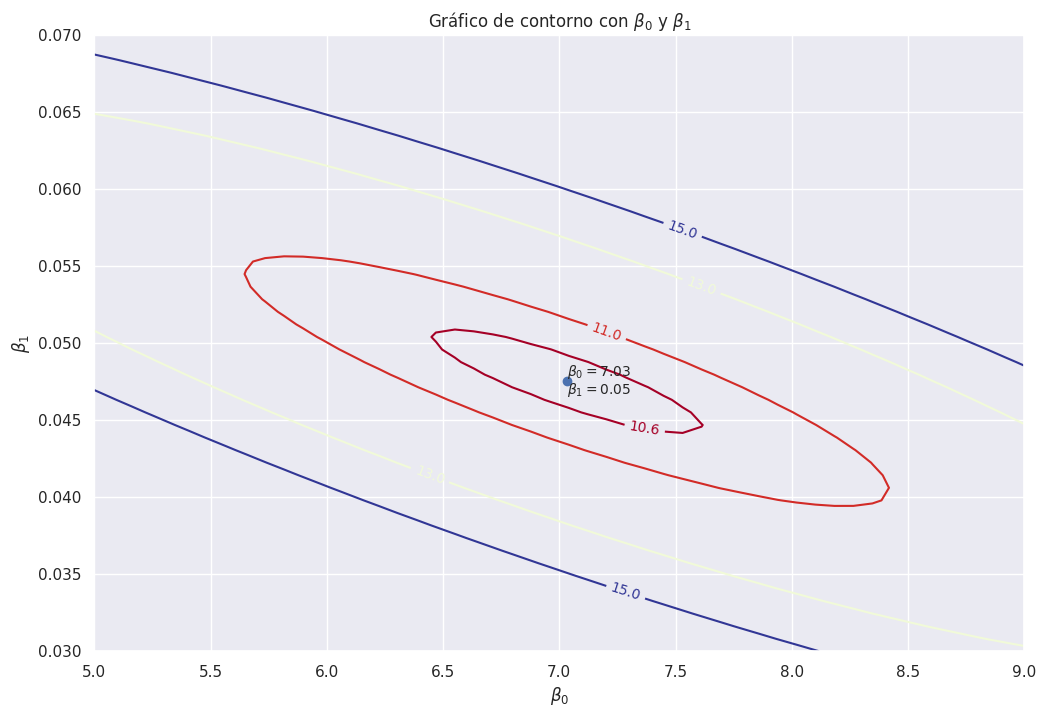

In [8]:
# Realizamos una malla de posibles valores cercanos a donde minimiza nuestra métrica
b0 = np.linspace(5, 9, 50)
b1 = np.linspace(.03, .07, 50)
# Generamos los diferentes valores que toma RSS para dichos valores
err = np.array([np.mean((df1['Sales'].values - (b_0 + b_1 * df1['TV'].values)) ** 2) for b_1 in b1 for b_0 in b0])
B0, B1 = np.meshgrid(b0, b1)
err_mesh = err.reshape(B0.shape)

plt.figure(figsize=(12,8))
fit = np.polyfit(df1['TV'], df1['Sales'], deg=1)
cs = plt.contour(B0, B1, err_mesh, cmap=plt.cm.RdYlBu, levels=[10.6, 11, 13, 15])
plt.clabel(cs, inline=1, fontsize=10)
plt.scatter(fit[1], fit[0]);

# Descripciones
plt.text(fit[1], fit[0], r'$\beta_0 = {:.2f}$'.format(fit[1]), fontsize=10, ha='left', va='bottom')
plt.text(fit[1], fit[0], r'$\beta_1 = {:.2f}$'.format(fit[0]), fontsize=10, ha='left', va='top')

plt.xlabel(r'$\beta_0$')
plt.ylabel(r'$\beta_1$')
plt.title('Gráfico de contorno con $\\beta_0$ y $\\beta_1$')
plt.show()

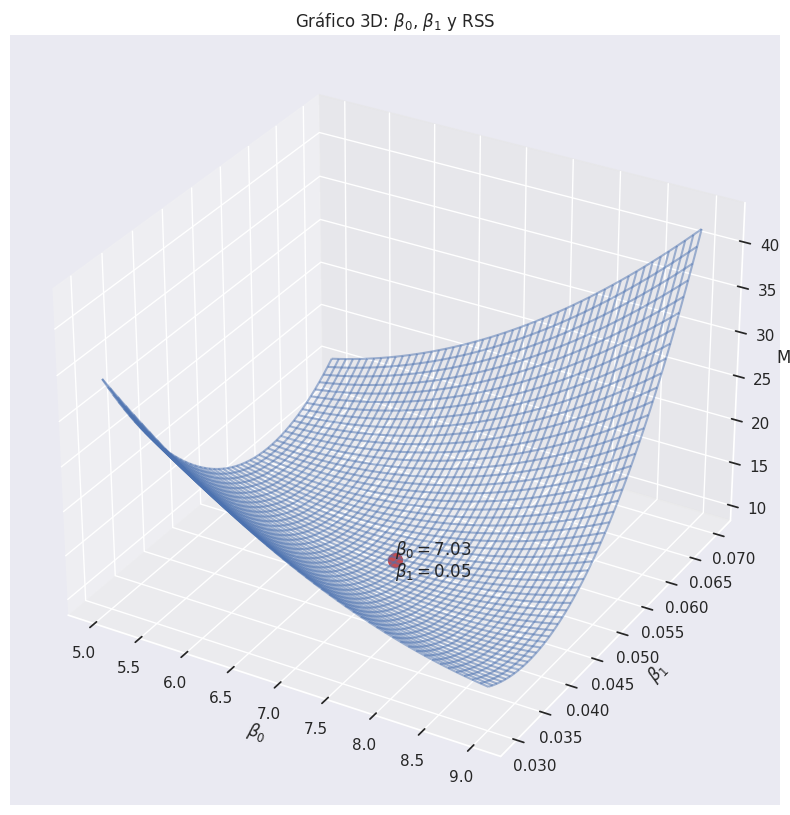

In [9]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(fit[1], fit[0], err_mesh.min(), s=100, c='r')
ax.plot_wireframe(B0, B1, err_mesh, alpha=.5);

# Agregar descripciones de los labels (betas) con formato LaTeX
ax.text(fit[1], fit[0], err_mesh.min(), r'$\beta_0 = {:.2f}$'.format(fit[1]), fontsize=12, ha='left', va='bottom')
ax.text(fit[1], fit[0], err_mesh.min(), r'$\beta_1 = {:.2f}$'.format(fit[0]), fontsize=12, ha='left', va='top')
ax.set_xlabel(r'$\beta_0$')
ax.set_ylabel(r'$\beta_1$')
ax.set_zlabel('MSE')
ax.set_title('Gráfico 3D: $\\beta_0$, $\\beta_1$ y RSS')
plt.show()

#### ¿Cómo obtenemos intervalos de confianza de nuestros parámetros?

<details>
<summary> Fundamento </summary>

Para encontrar los estimadores $\hat{\beta_0}$ y $\hat{\beta_1}$ usamos el método de mínimos cuadrados la cuál genera la *mejor recta*, sin embargo, debido a que solo estamos obteniendo la mejor estimación para esos datos proporcionados, surge la pregunta: *¿cuánto puede variar esta recta de una muestra a otra?*.

La fórmula para calcular el error estándar al cuadrado $\hat{SE}(\beta_0)^2$ y $\hat{SE}(\beta_1)^2$ respectivamente en una regresión lineal es:

$$
\hat{SE}(\beta_0)^2 = \sigma^2 \left[ \frac{1}{n} + \frac{\bar{x}^2}{\sum_{i=1}^{n} (x_i - \bar{x})^2} \right]
$$

$$
\hat{SE}(\beta_1)^2 = \frac{\sigma^2}{\sum_{i=1}^{n} (x_i - \bar{x})^2}
$$

Donde:
- $\sigma^2$ es la varianza de los errores de la regresión. Es decier $Var(\epsilon)$
- $n$ es el número de observaciones.
- $\bar{x}$ es el valor promedio de la variable predictora $x$.
- $x_i$ son los valores individuales de la variable predictora.


Finalmente para obtener los cálculos en ambos casos debemos estimar $\sigma$, mediante la siguiente fórmula:

$$
RSE = \sqrt{\frac{RSS}{n-2} }
$$

Con esto podemos calcular intervalos de confianza: (<span style="color:red">R1</span>).

$$
\hat{\beta_i} \pm t_{df}^{\alpha/2}  \hat{SE}(\beta_i) \mid  i = 0, 1
$$

In [29]:
# Definir las variables predictoras y la variable dependiente
X = df1['TV']
y = df1['Sales']

# Agregar intercepto
X = sm.add_constant(X)

# Ajustar un modelo de regresión lineal
model = sm.OLS(y, X).fit()

In [30]:
# Calcular intervalos de confianza para beta_0 y beta_1 (nivel de confianza del 95%)
conf_int = model.conf_int(alpha=0.05)

Aplicando los cálculos o en este caso, utilizando la libreria statmodels podemos obtener un intervalo estimado de que:

In [25]:
print('En promedio y sin ningún tipo de publicidad venderemos entre: ', round(conf_int.loc['const'][0],0) * 1000, ' y ' , round(conf_int.loc['const'][1],0) * 1000 , ' de unidades con un 95% de confianza.')

En promedio y sin ningún tipo de publicidad venderemos entre:  6000.0  y  8000.0  de unidades con un 95% de confianza.


In [179]:
print('Por cada $1000 de inversión en publicidad para TV se venderan entre: ' , round(conf_int.loc['TV'][0],3) * 1000 , ' y ' , round(conf_int.loc['TV'][1],3) * 1000 , ' de unidades con un 95% de confianza.')

Por cada $1000 de inversión en publicidad para TV se venderan entre:  42.0  y  53.0  de unidades con un 95% de confianza.


#### ¿Cómo validamos que nuestros parámetros sean significativos?

<details>
<summary> Fundamento </summary>

(<span style="color:red">R2</span>) Debemos realizar la prueba de hipótesis suele realizarse para comprobar si el predictor es diferente de 0. Tenemos que: 
$$
\begin{align*}
H_0: \beta_1 &= 0 \\
H_a: \beta_1 &\ne 0
\end{align*}
$$

Para probar esto averiguamos cuántos errores estándar se aleja nuestro parámetro de 0. Dicho de otra forma, calculamos nuestro estadístico $t$:
$$\frac{\hat{\beta_1} - 0}{SE(\hat{\beta_1})}$$

A continuación, se utiliza la distribución $t$ para determinar el porcentaje de veces que un valor aleatorio caería más allá de este estadístico t. Este porcentaje se denomina **valor P** y se utiliza como medida de lo extremos que son los resultados de los datos. Cuanto más pequeño es el valor $P$, más extremos son los resultados y más probable es que no procedan del azar.


In [119]:
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,7.0326,0.458,15.360,0.000,6.130,7.935
TV,0.0475,0.003,17.668,0.000,0.042,0.053


Por lo tanto para un $\alpha = 0.05$ podemos observar que para ambos parámetros rechazamos la hipótesis nula (pues $P \leq \alpha$), es decir, son significativos. Algo a tener en cuenta es que a según sea la trascendencia del análisis, debemos variar nuestro valor de $\alpha$ de 0.05 a 0.01. ¿Estarías dispuesto a correr el riesgo de tener un hijo con un margen de 5% o 1%?.

#### ¿Cómo medimos la eficiencia del modelo?

Recordemos de las diapositivas que nos valemos de distintas métricas para evaluar nuestros modelos, a continuación mostraremos los más imprescindibles para este análisis:

$$MRSE = \sqrt{\frac{1}{n - 2} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2} = \sqrt{\frac{RSS}{n - 2}}$$

La cuál podemos entender como la desviación media de la respuesta con respecto a la línea de regresión.

In [34]:
print('MSE = ' + str(round(model.mse_resid ** 0.5,2)))

MSE = 3.26


<details>
<summary> ¿Qué nos indica este valor en este contexto? </summary>

Nos indica que las ventas reales en para cada mercado se desvían de la línea de regresión real en aproximadamente 3260 promedio.


Por otro lado tenemos:

$$ R^2 = 1 - \frac{RSS}{TSS}  = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2 }{\sum_{i=1}^{n} (y_i - \bar{y})^2 }$$

Donde $TSS$ es el total de la suma de los cuadrados.De aquí podemos desprender que $R^2$ es la proporción de variabilidad en $Y$, explicada por $X$.

In [121]:
print('R2 = ' + str(round(model.rsquared,2)))

R2 = 0.61


<details>
<summary> ¿Qué nos indica este valor en este contexto? </summary>

Un número cercano a 1 indicaría un mejor ajuste. Para el modelo actual podemos decir 61% de la variación fue explicada por X (TV).

### 2.2.1.2. Regresión Múltiple

#### Contexto

Sin embargo, podemos ahora considerar todos los inputs que tenemos para construir un modelo más aceptable y que considere todos los canales de mercado.

In [38]:
model = smf.ols('Sales ~ TV + Newspaper + Radio', data=df1).fit()

In [123]:
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.9389,0.312,9.422,0.000,2.324,3.554
TV,0.0458,0.001,32.809,0.000,0.043,0.049
Newspaper,-0.0010,0.006,-0.177,0.860,-0.013,0.011
Radio,0.1885,0.009,21.893,0.000,0.172,0.206


#### ¿Qué podemos concluir de este nuevo modelo?

- Los parámetros de intercepto y TV, han variado al agregar nuevas características. Esto ya que nuestro modelo ahora esta tomando en juego la nueva información. 
- Interpretamos $\beta_j$ ($j$-ésimo predictor) como el efecto promedio en Y de un incremento de unidad en $X_j$ , manteniendo fijos todos los demás predictores.
- Todos los prédictores son significativos excepto $Newspaper$. ¿Por qué?

In [124]:
df1.corr()

,TV,Radio,Newspaper,Sales
TV,1.000000,0.054809,0.056648,0.782224
Radio,0.054809,1.000000,0.354104,0.576223
Newspaper,0.056648,0.354104,1.000000,0.228299
Sales,0.782224,0.576223,0.228299,1.000000


<details>
<summary> ¿Qué nos indica este valor en este contexto? </summary>

Una potencial causa del porque $Newspaper$ no es estadísticamente significativo lo podemos encontrar al revisar la correlación entre Newspaper y Radio, podemos observar que devirado a que existe una asociación sustancial entre ellas y que a su vez Radio esta altamante correlacionado de $Sales$, entonces por ende $Newspaper$ tiene ventaja de esta asociación. Recuerda, correlación no implica causalidad.

La hipótesis nula se amplía aquí para decir que todos los coeficientes son iguales a 0. La alternativa es sólo que al menos uno de ellos sea significativo. Se realiza una prueba F para comprobar la significación.
$$ F = \frac{(SST - SSE)/p}{SSE / (n - p - 1)}$$

Así también la forma de obtener el RSE:

$$RSE = \sqrt{\frac{RSS}{n - p - 1}}$$

Sin embargo, en el caso de $R^2$ con multiples inputs, al agregar más variables al modelo esta métrica puede aumentar (ya que de alguna forma cada variable explicará la variabilidad en $Y$), por ello se introduce:

$$R^2_{\text{ajustado}} = 1 - \frac{RSS / (n - p - 1)}{SST / (n - 1)}$$

Que buscará penalizar $R^2$ por cada nueva característica agregada.

In [125]:
model.summary().tables[0]

Dep. Variable:,Sales,R-squared:,0.897
Model:,OLS,Adj. R-squared:,0.896
Method:,Least Squares,F-statistic:,570.3
Date:,"Wed, 27 Sep 2023",Prob (F-statistic):,1.58e-96
Time:,17:28:44,Log-Likelihood:,-386.18
No. Observations:,200,AIC:,780.4
Df Residuals:,196,BIC:,793.6
Df Model:,3,,
Covariance Type:,nonrobust,,


#### Otras Consideraciones

##### Variables Predictoras Categóricas

Las variables no numéricas o numéricas pero que representan categorías se denominan variables categóricas. También se denominan variables cualitativas o factoriales.

Para ejemplificar el uso de variables categóricas, utilizaremos brevemente la TAD llamada **Credit**, la cuál recoge un conjunto de datos atemporales que contiene información sobre diez mil clientes. El objetivo es predecir el Balance en función de Gender.

| Variable   | Descripción                                           |
|------------|-------------------------------------------------------|
| Gender     | Género (Masculino o Femenino)                         |
| Balance    | Saldo promedio de la tarjeta de crédito en $          |

In [39]:
df2 = pd.read_csv(dir_data + 'credit.csv')[['Balance','Gender']]
df2.head(5)

,Balance,Gender
0,333,Male
1,903,Female
2,580,Male
3,964,Female
4,331,Male


In [41]:
pd.get_dummies(df2['Gender'], drop_first=True).value_counts() #Aplicación OHE

Female
True      207
False     193
Name: count, dtype: int64

In [42]:
df2['Gender'] = pd.get_dummies(df2['Gender'], drop_first=True)

In [44]:
model = smf.ols('Balance ~ Gender', data=df2).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,509.8031,33.128,15.389,0.000,444.675,574.931
Gender[T.True],19.7331,46.051,0.429,0.669,-70.801,110.267


<details>
<summary> ¿Qué nos dice el resultado? </summary>

En este caso, nuestro parámetro para $\beta_{Gender}$ indicará el valor agregado del Balance que se le aumentará asociado al genero, cómo en este caso $0$ esta asociado a Masculino y $1$ a Femenino el $Intercept$ esta asociado al promedio de la variable $Gender | Male$ 

###### Resultados

In [130]:
df2[df2['Gender'] == 1]['Balance'].mean()

529.536231884058

In [52]:
df2[df2['Gender'] == 0]['Balance'].mean() +  model.params['Gender[T.True]']

529.5362318840581

Queda claro de cualquier manera que aunque muy ilustrativo la explicación, no sirve de nada porque nuestro p-value nos indica que esta característica no es significativa.

##### Modelos de Interacción (Generación de nuevas características)

<span style="color:#8B0000">**Target: Venta Hogar**</span>  
<span style="color:#8B0000">**Característica 1: Metros de Largo**</span>  
<span style="color:#8B0000">**Característica 2: Metros de Ancho**</span>  
<span style="color:#8B0000">**Interacción: Metros al cuadrado**</span>  

Al considerar el modelo con las características mencionadas y su interacción, podemos obtener insights más profundos sobre la relación entre las dimensiones de un hogar y su precio de venta. La interacción, "Metros al cuadrado", nos permite explorar cómo el cambio conjunto en los "Metros de Largo" y "Metros de Ancho" afecta el valor del "Target: Venta Hogar". Es crucial evaluar la significancia de esta interacción para determinar si aporta información adicional valiosa para el modelo y si mejora nuestra capacidad para hacer predicciones precisas y confiables.


En una regresión lineal común no hay efectos de interacción (es decir, no hay dos características que se multipliquen juntas) y el supuesto es que un aumento de una unidad en una variable no tendrá ningún efecto sobre otra variable. En muchos problemas del mundo real, el aumento de una variable puede cambiar el impacto que otra variable tiene en la respuesta. Para captar este efecto en la regresión múltiple, multiplicamos los predictores entre sí, este efecto se le conoce como **Interacción**.

In [53]:
# interaction model
model_interactions = smf.ols('Sales ~ TV + Radio + TV * Radio', data=df1).fit()
model_interactions.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,6.7502,0.248,27.233,0.000,6.261,7.239
TV,0.0191,0.002,12.699,0.000,0.016,0.022
Radio,0.0289,0.009,3.241,0.001,0.011,0.046
TV:Radio,0.0011,5.24e-05,20.727,0.000,0.001,0.001


Podemos interpretar a $\beta_{TV:Radio}$ como el aumento de la eficacia (o impacto) de la publicidad televisiva asociado a un aumento de una unidad en la publicidad radiofónica (o viceversa, esto estará mejor determinado si entendemos de manera teorica la relación causal, pero esto esta fuera de nuestro objetivo).

In [54]:
model_w_interactions = smf.ols('Sales ~ TV + Radio', data=df1).fit()

In [55]:
model_interactions.rsquared

0.9677905498482523

In [56]:
model_w_interactions.rsquared

0.8971942610828956

Podemos notar que nuestro parámetro es significativo. Nuestro parámetro se lee de la siguiente manera: Un incremento en publicidad en TV de 1 unidad (*$\$1000$*) esta asociado con el incremento en ventas de: 
$$(\hat{\beta}_{TV} + \hat{\beta}_{TV:Radio} \times radio) \times 1000 = 19 + 1.1 \times radio$$
A su vez, un incremento en publicidad de radio de 1 unidad o  *$\$1000$* esta asociado con el incremento en ventas de:
$$(\hat{\beta}_{Radio} + \hat{\beta}_{TV:Radio} \times TV) \times 1000 = 29 + 1.1 \times radio$$ 

##### Relaciones No lineales

A pesar de que la línea de regresión puede ser visiblemente no lineal, el hecho de elevar al cuadrado las variables predictoras sigue significando que estamos realizando una regresión lineal. Los requisitos para que una regresión sea "lineal" es que sea lineal en los parámetros.

Para ejemplificar lo anterior, utilizaremos brevemente la TAD llamada **Auto**, la cuál recoge información de consumo de combustible, caballos de fuerza y otros detalles para 392 vehículos. Nuestro objetivo será predecir mpg con base a los caballos de fuerza del motor.

| Variable     | Descripción                                       |
|--------------|---------------------------------------------------|
| mpg          | Millas por galón                                 |
| horsepower   | Caballos de fuerza del motor                     |
| name         | Nombre del vehículo                              |


In [58]:
df3 = pd.read_csv(dir_data + 'auto.csv')[['mpg', 'horsepower','name']]
df3[df3.select_dtypes(exclude='object').columns] = df3.select_dtypes(exclude='object').astype(float)

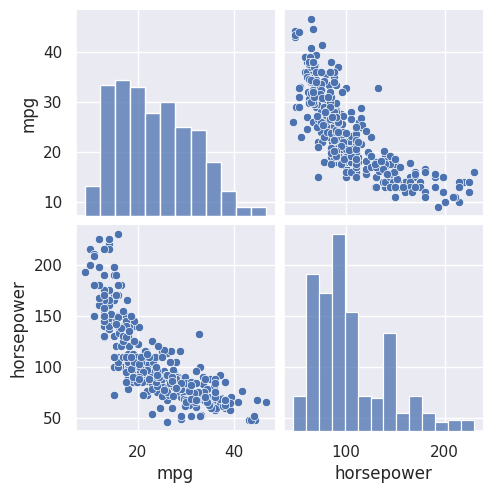

In [59]:
sns.pairplot(df3);

<details>
<summary> ¿Qué nos dice el gráfico acerca de las relaciones entre nuestro inputs y output? </summary>

Podemos ver que existe una relación entre nuestras variables, pero ¿esta es lineal?.

In [60]:
df3.select_dtypes(include=['number']).corr()

,mpg,horsepower
mpg,1.000000,-0.778427
horsepower,-0.778427,1.000000


In [61]:
model = smf.ols('mpg ~ horsepower', data=df3).fit()
display(model.summary().tables[1])
print(np.round(model.rsquared,4))

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,39.9359,0.717,55.660,0.000,38.525,41.347
horsepower,-0.1578,0.006,-24.489,0.000,-0.171,-0.145


0.6059


In [62]:
model = smf.ols('mpg ~  horsepower + np.power(horsepower,2)', data=df3).fit()
display(model.summary().tables[1])
print(np.round(model.rsquared,4))

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,56.9001,1.800,31.604,0.000,53.360,60.440
horsepower,-0.4662,0.031,-14.978,0.000,-0.527,-0.405
"np.power(horsepower, 2)",0.0012,0.000,10.080,0.000,0.001,0.001


0.6876


##### Supuestos del Modelo

En un modelo de regresión lineal, es esencial verificar que se cumplen ciertas condiciones subyacentes para que las conclusiones sean sólidas. En la vida real, es difícil que todas estas condiciones se cumplan completamente, pero esto no invalida el modelo. Lo crucial es ser consciente de estas limitaciones y entender cómo pueden afectar las conclusiones que se obtienen.

**Multicolinealidad**

En modelos de regresión lineal múltiple, es esencial que las variables predictoras no estén relacionadas entre sí de manera muy cercana. Esto se llama colinealidad o multicolinealidad. Cuando esto sucede, se vuelve difícil determinar con precisión cómo cada variable afecta la variable de respuesta. Los coeficientes de regresión estimados se vuelven inestables y no se pueden evaluar estadísticamente. Incluso pequeños cambios en los datos pueden llevar a grandes cambios en las estimaciones de los coeficientes. Aunque la colinealidad perfecta es rara, la multicolinealidad menos extrema es bastante común en la práctica. **¿Cómo desciframos si nuestro modelo sufre de multicolinealidad?**

<details>
<summary> R2 y p-values </summary>

**Resumen del Modelo**
- **Modelo:** Regresión Lineal
- **Variable de Respuesta:** Precio de la Casa
- **Variables Predictoras:** Tamaño de la Casa (Sqft), Número de Habitaciones, Edad de la Casa (Years)

**Resultados Generales**
- **$R^2$:** 0.85
- **Valor p global:** 0.12

**Coeficientes de Regresión**
- Tamaño de la Casa (Sqft): 300 (p = 0.20)
- Número de Habitaciones: -50 (p = 0.35)
- Edad de la Casa (Years): 20 (p = 0.28)


<details>
<summary> ¿Qué nos dice este reporte? </summary>

A pesar de la alta $R^2$, ninguno de los coeficientes de regresión es estadísticamente significativo (p > 0.05). Esto sugiere que, aunque el modelo puede ajustarse bien a los datos en términos de $R^2$, las variables predictoras no tienen un efecto individualmente significativo en el precio de la casa.

Esto podría indicar la presencia de multicolinealidad, donde las variables predictoras están altamente correlacionadas entre sí. Como resultado, se vuelve difícil discernir el impacto individual de cada variable.

Se recomienda realizar un análisis adicional para identificar la multicolinealidad y considerar la eliminación o transformación de las variables predictoras si es necesario.



<details>
<summary> Cálculo del Factor de Inflación de la Varianza (VIF) </summary>

El VIF cuantifica cuánto aumenta la varianza de los coeficientes de regresión debido a la multicolinealidad. Un VIF alto indica una alta multicolinealidad. Se calcula para cada variable predictora en el modelo. La fórmula general para el VIF de una variable predictora $X_i$ es la siguiente:
$$VIF_{\hat{\beta_i}} = \frac{1}{1 - R^2_i}$$

Donde:
- $R^2_i$ es el coeficiente de determinación $R^2$ resultante de regresar $X_i$ frente a todas las demás variables predictoras.

**Interpretación del VIF**

- Si $VIF_{\hat{\beta_i}} = 1 \implies$ No hay multicolinealidad entre la variable predictora $X_i$ y las otras variables en el modelo.

- Si $1<VIF_{\hat{\beta_i}}<5 \implies$  Multicolinealidad moderada. Aún se considera aceptable según el contexto.

- Si $5 \leq VIF_{\hat{\beta_i}}\implies$ Multicolinealidad alta. En este caso, la varianza del coeficiente de regresión de $X_i$ se ha inflado significativamente debido a la multicolinealidad.

<details>
<summary> Acciones a tomar </summary>

- Eliminar una de las variables altamente correlacionadas.
- Combinar variables relacionadas en una sola (interacciones).
- Realizar una transformación de variables (PCA).


In [64]:
df3 = pd.read_csv(dir_data + 'auto.csv')[['mpg', 'horsepower', 'weight','acceleration']]
df3[df3.select_dtypes(exclude='object').columns] = df3.select_dtypes(exclude='object').astype(float)

# Separar las variables predictoras y la variable de respuesta
X = df3[['mpg', 'horsepower', 'weight']]
y = df3['mpg']

# Calcular los VIF
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
display(vif)

,Variable,VIF
0,mpg,3.597552
1,horsepower,34.011611
2,weight,40.681296


**Relación Lineal entre los predictores y la variable respuesta** 

La relación entre las variables predictoras y la variable de respuesta debe ser lineal. Esto significa que los cambios en las variables predictoras deben asociarse con cambios proporcionales en la variable de respuesta. Si la relación es lineal, al graficar los valores actuales vs. predichos podemos ver una distribución relativamente uniforme alrededor de la línea identidad.

**Normalidad de errores**

Los errores deben seguir una distribución normal. Esto implica que la distribución de los residuos debe ser aproximadamente simétrica y centrada en cero. Esto lo podemos validar graficamente con un histograma, gráfico Q-Q de los residuos (comparando la distribución de los residuos con una distribución teórica normal) si los puntos siguen una línea diagonal, los residuos se ajustan a una distribución normal y finalmente con pruebas de normalidad de los residuales.

**Homocedasticidad**

La varianza de los errores debe ser constante en todos los niveles de las variables predictoras. Esto se puede apreciar graficamente comparando residuos vs. valores ajustados y verificar que no existan patrones (debe estar los valores entorno a la recta 0).

**No autocorrelación en Errores**

Para asegurar la no autocorrelación en la regresión lineal, es importante que los valores de cada observación sean independientes entre sí, especialmente en datos temporales. El gráfico de autocorrelación de residuos es útil para verificar si los residuos exhiben alguna correlación serial o autocorrelación en función del tiempo. Si los residuos son independientes, no debería haber patrones significativos en el gráfico de autocorrelación. También, puedes utilizar pruebas estadísticas como el test de hipótesis de Durbin-Watson para evaluar la independencia de los residuos.



In [66]:
# Variables predictoras (X) y variable de respuesta (y)
X = df1[['TV','Radio']]
y = df1['Sales']

# División de los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y.values.reshape(-1, 1),  # Reshape para asegurarte de tener una columna
    train_size=0.8,           # Tamaño del conjunto de entrenamiento
    random_state=1234,        # Semilla aleatoria para reproducibilidad
    shuffle=True              # Mezcla los datos antes de dividir
)

# Agregar intercepto
X = sm.add_constant(X_train)

# Ajustar un modelo de regresión lineal
X_train = sm.add_constant(X_train, prepend=True)
model = sm.OLS(y_train,X_train)
model = model.fit()
y_pred = model.predict(X_train)

Shapiro-Wilk Test: Debe rechazarse la hipótesis nula de que los datos proceden de una distribución normal. P-value: 0.0
D'Agostino Test: Debe rechazarse la hipótesis nula de que los datos proceden de una distribución normal. P-value: 0.0
Estadístico de Durbin-Watson: 2.1566401465079394: No hay indicios significativos de autocorrelación.


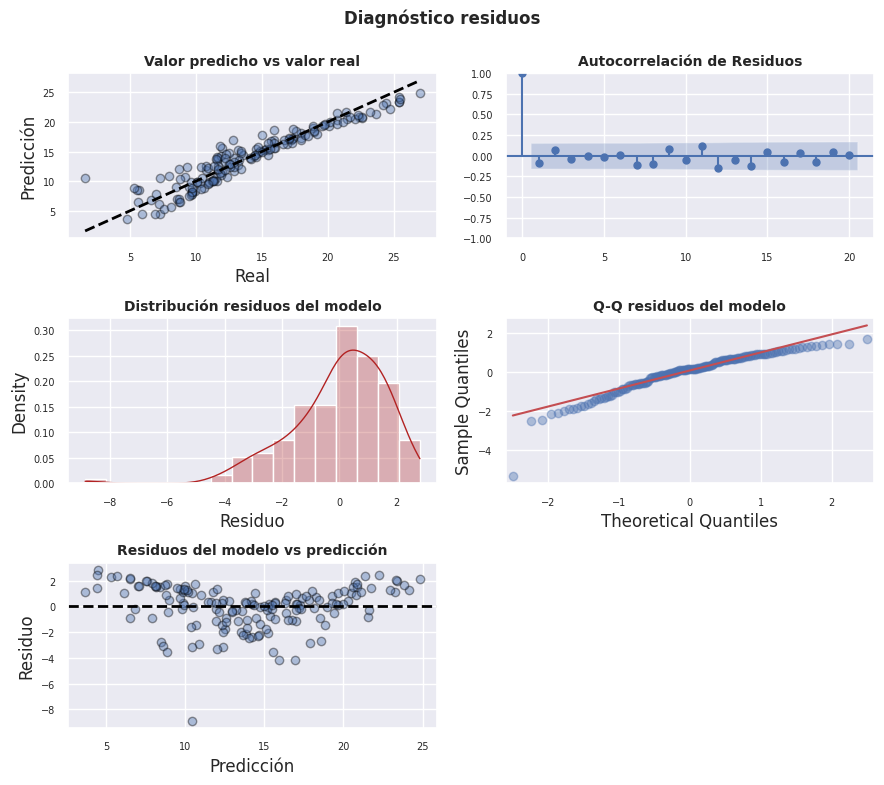

In [67]:
general_diagnosis(y_train.flatten(),y_pred,0.05)

### 2.2.1.3. Ejemplo

In [76]:
#api = KaggleApi()
#api.authenticate()
#api.dataset_download_files('mirichoi0218/insurance', path=dir_data, unzip=True)

df = pd.read_csv(dir_data + 'insurance.csv')

#### Análisis Exploratorio de Datos

| Variable   | Descripción                                                                                                           |
|------------|-----------------------------------------------------------------------------------------------------------------------|
| age        | Edad del beneficiario principal.                                                                                     |
| sex        | Género del contratante del seguro, femenino o masculino.                                                             |
| bmi        | Índice de Masa Corporal (BMI), que proporciona una comprensión del peso corporal en relación con la altura. Es un índice objetivo del peso corporal (kg/m²) utilizando la proporción de altura y peso, idealmente entre 18.5 y 24.9.   |
| children   | Número de hijos cubiertos por el seguro de salud / Número de dependientes.                                            |
| smoker     | Hábito de fumar del beneficiario (fumador o no fumador).                                                               |
| region     | Área de residencia del beneficiario en los Estados Unidos, noreste, sureste, suroeste, noroeste.                      |
| charges    | Costos médicos individuales facturados por el seguro de salud.                                                        |


In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [78]:
df.children.sort_values().unique()

array([0, 1, 2, 3, 4, 5])

In [79]:
df.children[df.children >= 3] = 3
df['children'] = df['children'].astype('str')

In [80]:
# Definición de Variables
variables_numericas = df.select_dtypes(include=['number']).drop('charges',axis=1).columns.tolist()
variables_categoricas = df.select_dtypes(include=['object']).columns.tolist()
target = ['charges']

In [83]:
display(df.describe())
display(df.describe(include=['object']))

,age,bmi,charges
count,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,13270.422265
std,14.049960,6.098187,12110.011237
min,18.000000,15.960000,1121.873900
25%,27.000000,26.296250,4740.287150
50%,39.000000,30.400000,9382.033000
75%,51.000000,34.693750,16639.912515
max,64.000000,53.130000,63770.428010


,sex,children,smoker,region
count,1338,1338,1338,1338
unique,2,4,2,4
top,male,0,no,southeast
freq,676,574,1064,364


In [84]:
pd.DataFrame(df.isnull().sum(),columns = ['NA'])

,NA
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0


<Figure size 1200x800 with 0 Axes>

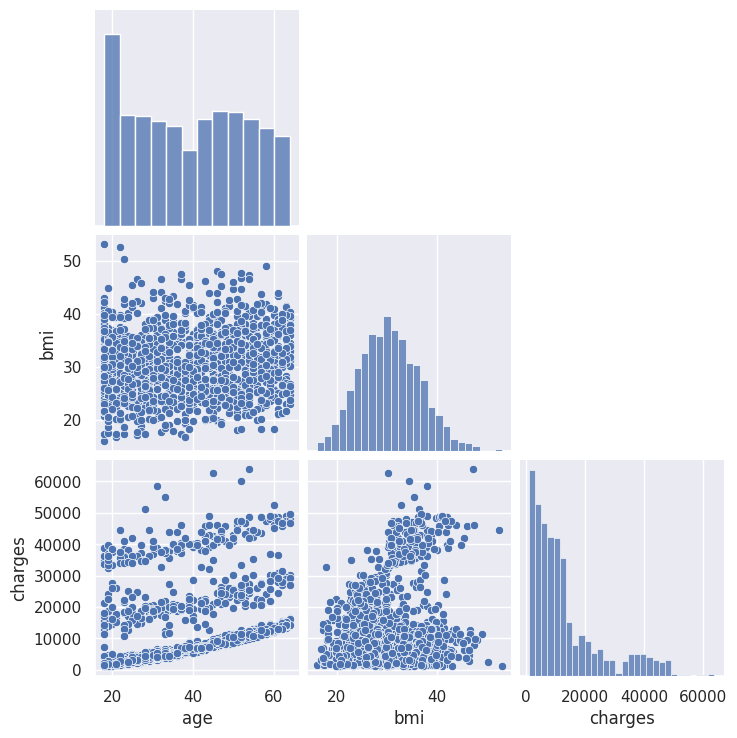

In [85]:
plt.figure(figsize=(12, 8));
sns.pairplot(data=df[variables_numericas+target] , corner=True);

In [86]:
df.select_dtypes(include=['number']).corr()

,age,bmi,charges
age,1.000000,0.109272,0.299008
bmi,0.109272,1.000000,0.198341
charges,0.299008,0.198341,1.000000


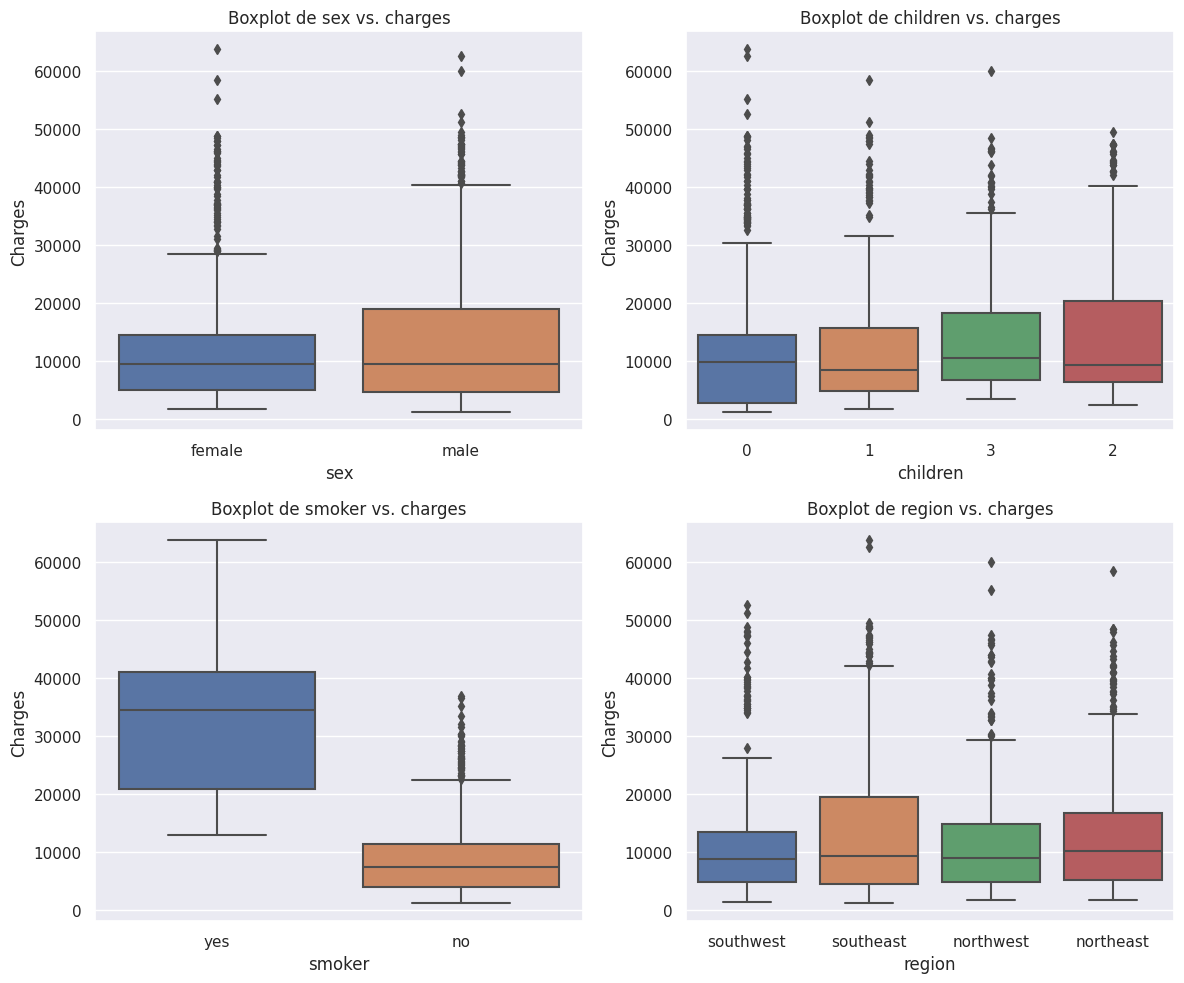

In [201]:
boxplot_target(var_cat=variables_categoricas,target='charges')

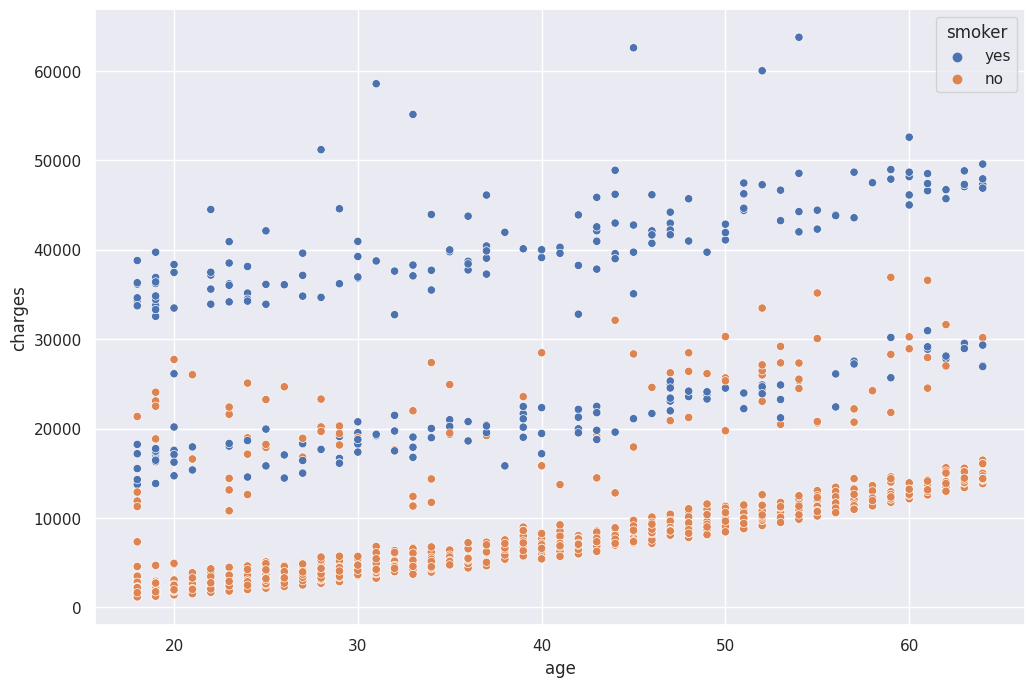

In [202]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=df, x='age', y='charges',hue='smoker')
plt.show()

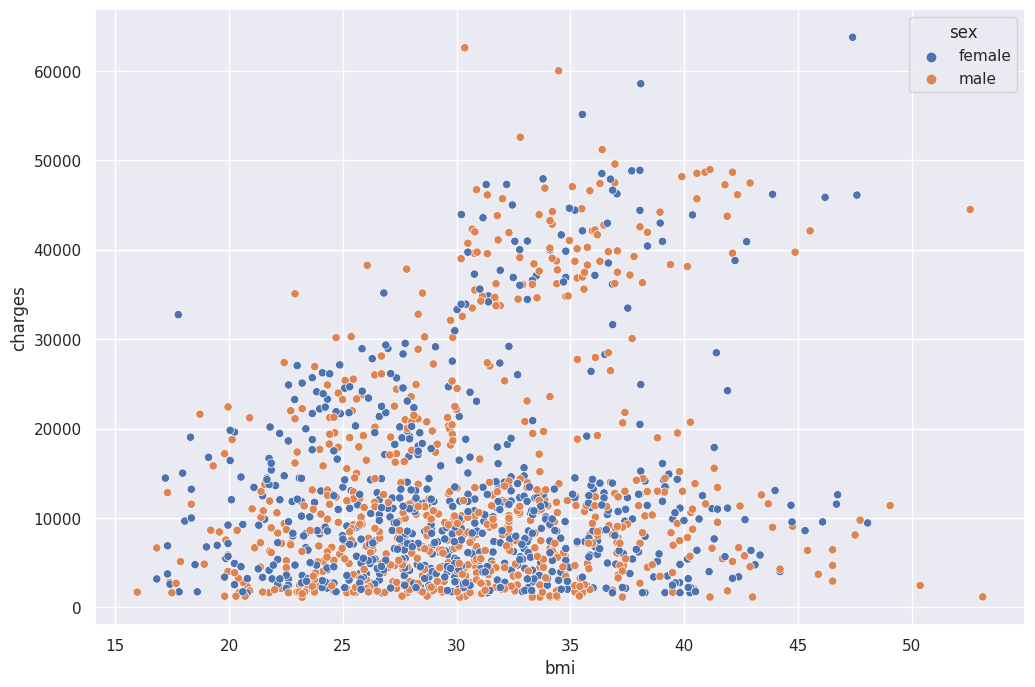

In [203]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=df, x='bmi', y='charges',hue='sex')
plt.show()

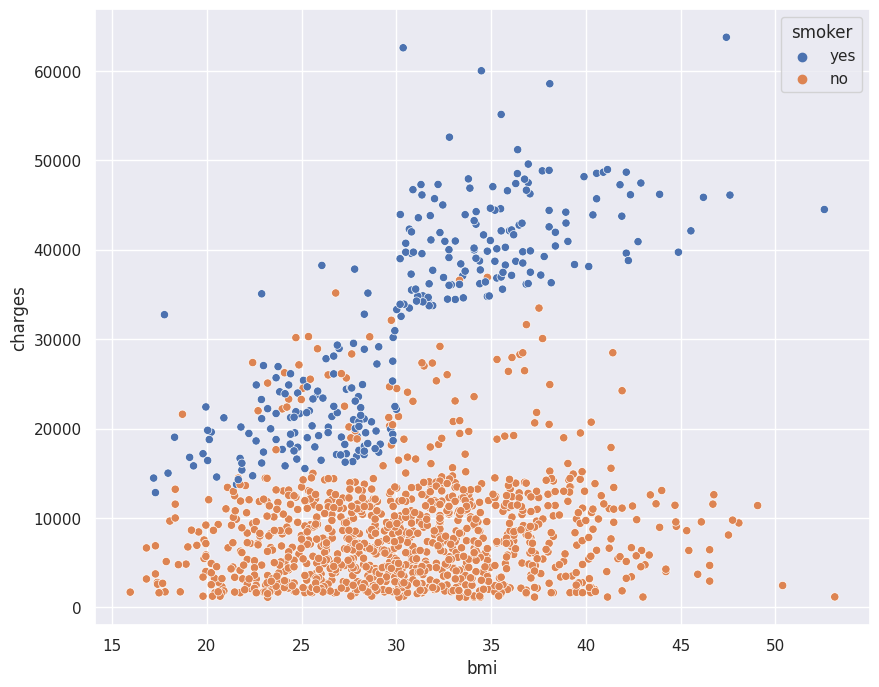

In [204]:
plt.figure(figsize=(10,8))
sns.scatterplot(x='bmi', y='charges',data=df, hue='smoker')
plt.show()

#### División Train-Test y Premodelado

In [88]:
X = df.drop('charges',axis=1)
y = df['charges']

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7,random_state=333,shuffle=True)

In [91]:
variables_numericas

['age', 'bmi']

In [96]:
# Transformación Paralela
preprocesado = ColumnTransformer(
                   [#('scale', StandardScaler(), variables_numericas ),
                    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first',sparse=False), variables_categoricas)],
                     remainder='passthrough') #Garantiza que columnas que no están sujetas a ninguna transformación se incluyan en el conjunto de datos transformado.

X_train_pp = preprocesado.fit_transform(X_train)
X_test_pp  = preprocesado.transform(X_test)

In [99]:
# K-BEST
kbest = SelectKBest(score_func=f_regression, k=5)  
X_train_kbest = kbest.fit_transform(X_train_pp, y_train)
kbest = pd.DataFrame({'Feature': X_train_pp.columns, 'Score': kbest.scores_}).sort_values(by='Score', ascending=False)
kbest

,Feature,Score
4,onehot__smoker_yes,1392.813665
8,remainder__age,97.546406
9,remainder__bmi,38.725208
2,onehot__children_2,8.918795
6,onehot__region_southeast,4.250754
1,onehot__children_1,3.230983
7,onehot__region_southwest,2.885789
3,onehot__children_3,1.284496
0,onehot__sex_male,0.781151
5,onehot__region_northwest,0.302014


In [100]:
get_cols = kbest[kbest['Score']>20].Feature.tolist()
X_train_pp = X_train_pp[get_cols]
X_test_pp = X_test_pp[get_cols]

#### Modelado

In [103]:
model_lr1 = LinearRegression()
model_lr1.fit(X_train_pp,y_train)

# Crear un DataFrame para almacenar los coeficientes
coeficientes_df = pd.DataFrame({'Variable': X_train_pp.columns, 'Coeficiente': model_lr1.coef_.flatten()})
display(coeficientes_df)
print('intercept:',model_lr1.intercept_)
print('R2:', model_lr1.score(X_train_pp, y_train))

,Variable,Coeficiente
0,onehot__smoker_yes,23393.040596
1,remainder__age,266.287256
2,remainder__bmi,315.770248


intercept: -11726.933258919806
R2: 0.7369187084275604


In [105]:
# Añadir una constante (intercepto) al DataFrame 
X_train_stats = sm.add_constant(X_train_pp)

# Ajustar un modelo de regresión lineal en statsmodels
modelo_stats1 = sm.OLS(y_train, X_train_stats).fit()
display(modelo_stats1.summary().tables[1])
print('rsquared:',modelo_stats1.rsquared)

,coef,std err,t,P>|t|,[0.025,0.975]
const,-1.173e+04,1104.703,-10.615,0.000,-1.39e+04,-9558.940
onehot__smoker_yes,2.339e+04,501.889,46.610,0.000,2.24e+04,2.44e+04
remainder__age,266.2873,14.177,18.783,0.000,238.465,294.110
remainder__bmi,315.7702,32.081,9.843,0.000,252.812,378.729


rsquared: 0.7369187084275604


In [106]:
# Otra forma de generar interacciones polinómicas
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
X_train_pp_int = poly.fit_transform(X_train_pp)

X_test_pp_int = poly.transform(X_test_pp)

In [108]:
# Statmodels
X_train_pp_int_cons = sm.add_constant(X_train_pp_int)
modelo_stats2 = sm.OLS(y_train,X_train_pp_int_cons).fit()
display(modelo_stats2.summary().tables[1])
print('rsquared:',modelo_stats2.rsquared)
# Se eliminaron la mayoria de variables poco significativas

,coef,std err,t,P>|t|,[0.025,0.975]
const,2186.1497,2406.150,0.909,0.364,-2535.969,6908.269
onehot__smoker_yes,-1.879e+04,2188.657,-8.583,0.000,-2.31e+04,-1.45e+04
remainder__age,154.0742,58.497,2.634,0.009,39.273,268.876
remainder__bmi,-151.2311,77.328,-1.956,0.051,-302.988,0.526
onehot__smoker_yes remainder__age,-1.1301,28.984,-0.039,0.969,-58.012,55.752
onehot__smoker_yes remainder__bmi,1377.8167,61.755,22.311,0.000,1256.621,1499.012
remainder__age remainder__bmi,3.9553,1.849,2.139,0.033,0.327,7.584


rsquared: 0.828864810939287


In [109]:
X_train_pp_int.drop( 'onehot__smoker_yes remainder__age',inplace=True,axis=1)
X_test_pp_int.drop( 'onehot__smoker_yes remainder__age',inplace=True,axis=1)

In [110]:
# Statmodels
#X_train_pp_int_cons = sm.add_constant(X_train_pp_int)
modelo_stats3 = sm.OLS(y_train,X_train_pp_int).fit()
display(modelo_stats3.summary().tables[1])

r2_score(y_true=y_train,
         y_pred=modelo_stats3.predict(X_train_pp_int))

,coef,std err,t,P>|t|,[0.025,0.975]
onehot__smoker_yes,-1.841e+04,1878.791,-9.800,0.000,-2.21e+04,-1.47e+04
remainder__age,203.0181,22.320,9.096,0.000,159.215,246.821
remainder__bmi,-82.0328,15.618,-5.253,0.000,-112.682,-51.383
onehot__smoker_yes remainder__bmi,1364.3343,59.885,22.783,0.000,1246.809,1481.860
remainder__age remainder__bmi,2.4151,0.757,3.189,0.001,0.929,3.901


0.8287109817465363

In [111]:
# Modelo sin intercepción
lr = LinearRegression(fit_intercept=False)
lr.fit(X_train_pp_int, y_train)
print('R2',r2_score(y_train, lr.predict(X_train_pp_int)))
print('RMSE: ',np.sqrt(mean_squared_error(y_train, lr.predict(X_train_pp_int))))


R2 0.8287109817465363
RMSE:  4890.312332836274


#### Test

In [116]:
cv_scores = cross_val_score(estimator = lr,
                X= X_test_pp_int, y= y_test,
                scoring ='r2',
                cv=RepeatedKFold(n_splits=10, n_repeats=5, random_state=333),
                n_jobs    = -1
            )

print(f"Train R2 en CV: mean {np.mean(cv_scores)}, std: {np.std(cv_scores)}")

Train R2 en CV: mean 0.8466387271901309, std: 0.058097721560685996


In [117]:
cv_scores = cross_validate(
                estimator = lr,
                X         = poly.transform(X_test_pp),
                y         = y_test,
                scoring   = ('r2', 'neg_root_mean_squared_error'),
                cv        = RepeatedKFold(n_splits=10, n_repeats=5, random_state=333),
            )


In [121]:
cv_scores = cross_validate(
                estimator = lr,
                X         = poly.transform(X_test_pp),
                y         = y_test,
                scoring   = ('r2', 'neg_root_mean_squared_error'),
                cv        = RepeatedKFold(n_splits=10, n_repeats=5, random_state=333),
            )


# Se convierte el diccionario a dataframe para facilitar la visualización
cv_scores = pd.DataFrame(cv_scores)
print(f"R2 en CV: mean {np.median(cv_scores.test_r2)}, std {np.std(cv_scores.test_r2)}")
print(f"RMSE en CV: mean {-np.median(cv_scores.test_neg_root_mean_squared_error)}, std {np.std(cv_scores.test_neg_root_mean_squared_error)}")

R2 en CV: mean 0.8573348277586763, std 0.05828959269049544
RMSE en CV: mean 4672.208814226606, std 988.9943233563373


**Guardar modelo:**

In [122]:
pd.to_pickle(lr,'./01_Models/lr.pkl')

In [123]:
pd.read_pickle('./01_Models/lr.pkl')

LinearRegression(fit_intercept=False)